# Adjusting PC-SAFT parameters for a non-associating, non-polar substance

## Goal

- Read in experimental data for vapor pressure and liquid density of a pure substance.
- Use the `DataSet`, `Loss` and `Estimator` objects to store and work with experimental data.
- Define a `cost` function that will be used with `scipy.optimize.least_squares`.
- Run the optimization.

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
import seaborn as sns

from feos.si import *
from feos.eos import *
from feos.pcsaft import *
from feos.eos.estimator import Estimator, Loss, DataSet

sns.set_context('talk')
sns.set_palette('Dark2')
sns.set_style('ticks')
colors = sns.palettes.color_palette('Dark2', 5)

# `DataSet` objects

FeO$_\text{s}$ provides a range of data structures that facilitate the adjustment of parameters. One such structure is the `DataSet`, which serves as a storage unit for experimental data. When working with a specific model, a `DataSet` enables the evaluation of the relative difference between the model's prediction and the experimental value of the desired property.

A DataSet encompasses the following components:

- The `target`: This refers to the experimental data associated with the property for which we intend to adjust parameters. In our case, these properties include vapor pressures and liquid densities. Additional options consist of dynamic properties used to adjust correlation parameters for entropy scaling or VLE (Vapor-Liquid Equilibrium) data of mixtures to fine-tune binary interaction parameters.
- Other properties: These are necessary for determining the thermodynamic conditions. For instance, temperature is required for vapor pressure calculations, while liquid density computations necessitate temperature and pressure.
- Each property available in FeO$_\text{s}$ is accompanied by a corresponding DataSet constructor.

Below, we load (pseudo) experimental data for hexane's vapor pressures and liquid densities. The data, derived from the NIST WebBook, incorporates simulated statistical uncertainties (e.g., measurement errors) by introducing Gaussian noise.

In [2]:
# read data from file into DataFrame
data_psat = pd.read_csv("data/hexane_vapor_pressure.csv")
# construct a `DataSet` for vapor pressure
dataset_psat = DataSet.vapor_pressure(
    target=data_psat["vapor_pressure / bar"].values * BAR,
    temperature=data_psat["temperature / K"].values * KELVIN,
    extrapolate=True
)

For `DataSet.vapor_pressure` we have to supply the experimental data for vapor pressures and temperatures as input.

Optional parameters are
- `extrapolate` which allows an extrapolation for experimental data above the model's critical temperature (using an Antoine-like equation),
- `critical_temperature` when the experimental critical temperature is known,
- `max_iter` for the VLE solver, and
- `verbosity` to print the solver iterations to the console.

In [3]:
# read data from file into DataFrame
data_rhol = pd.read_csv("data/hexane_liquid_density.csv")
# construct a `DataSet` for liquid density
dataset_rhol = DataSet.liquid_density(
    target=data_rhol["density / kg/m3"].values * KILOGRAM / METER**3,
    temperature=data_rhol["temperature / K"].values * KELVIN,
    pressure=data_rhol["pressure / bar"].values * BAR
)

For `DataSet.liquid_density` we have to supply the experimental data for liquid mass densities, temperatures and pressures as input.

# `Estimator` and `Loss` objects

To collect the `DataSet` objects for the properties we wish to adjust parameters for, we can assemble them into an `Estimator` object. The `Estimator` requires the following inputs:

- A list of `DataSet` objects.
- A corresponding list of `weights`, with each weight assigned to a specific `DataSet`.
- A list of `losses`, where each `DataSet` has an associated loss function.

The `Estimator` facilitates the calculation of the model's `cost`, which involves the following steps:

1. Iterating through all `DataSets`: For each `DataSet`, the relative difference between the model's prediction and the experimental data is evaluated.
2. Application of a `Loss` function: The available `Loss` functions in FeO$_\text{s}$ are identical to those found in [`scipy.optimize.least_squares`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html). Each property can have a different `Loss`. If `Loss.linear()` is used, the optimization simplifies to a regular least-squares problem.
3. Normalization: The relative differences (with the applied loss functions) are divided by the number of data points in each corresponding `DataSet`.
4. Weighted cost calculation: The costs of each `DataSet` are weighted based on the provided (normalized) `weights`.

The following example demonstrates the construction of an estimator using vapor pressure and liquid density data. We utilize `weights = [3, 2]` (normalized `weights = [0.6, 0.4]`) and a `Loss.huber(0.05)` loss function, which treats predictions above 0.05% linearly in the cost function instead of squaring them (outlier treatment).


In [4]:
estimator = Estimator(
    data=[dataset_psat, dataset_rhol],
    weights=[3, 2],
    losses=[Loss.huber(0.05), Loss.huber(0.05)]
)

When using `scipy`'s `least_squares` solver, it requires a function to calculate the cost or residuals. The first argument of this function should be the parameter vector being optimized. Therefore, it is necessary to define this function in Python before working with `least_squares`.

To simplify the process, we create two functions:

- `eos_from_parameters`: This function constructs the parameters and equation of state based on the current parameter vector. Since FeO$_\text{s}$ does not allow mutation of an existing `EquationOfState` object, generating a new equation of state is necessary. We can use this function later to generate the equation of state for the final parameters.
- `cost`: Taking the parameters and estimator as inputs, this function builds the equation of state, calculates the cost of the current model, and returns the result.

These functions aid in the seamless integration of the solver, allowing for the generation of the equation of state and the calculation of the model's cost.

In [5]:
# define things that are constant during optimization
identifier = Identifier(
    cas="110-54-3", 
    name="hexane", 
    iupac_name="hexane", 
    smiles="CCCCCC", 
    inchi="InChI=1/C6H14/c1-3-5-6-4-2/h3-6H2,1-2H3", 
    formula="C6H14"
)
molarweight = 86.177 # g / mol

def eos_from_parameters(p):
    """Returns equation of state (PC-SAFT) for current parameters."""
    global identifier, molarweight
    m, sigma, epsilon_k = p
    model_record = PcSaftRecord(m, sigma, epsilon_k)
    pure_record = PureRecord(identifier, molarweight, model_record)
    parameters = PcSaftParameters.new_pure(pure_record)
    return EquationOfState.pcsaft(parameters)

def cost(p, estimator):
    """Calculates cost function for current parameters."""
    eos = eos_from_parameters(p)
    return estimator.cost(eos)

# Adjust parameters

To begin parameter adjustment, there are two additional requirements:

1. An initial guess for the parameters.
2. Bounds for the parameters.

It is crucial to note that trying multiple combinations of initial parameters is recommended to avoid getting stuck in a local optimum.

Once these prerequisites are fulfilled, we can invoke `least_squares` with `args=(estimator, )` as an argument for the `cost` function. Please note that the tuple syntax is necessary in this case.

In [6]:
%%time
initial_parameters = [3.0, 3.0, 300.0] # m, sigma, epsilon_k
bounds = ([2.0, 2.0, 150.0], [8.0, 5.0, 500.0]) # ([lower bounds], [upper bounds])
fitted_parameters = least_squares(cost, initial_parameters, bounds=bounds, args=(estimator,), verbose=2).x

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         9.6023e-05                                    1.11e-04    
       1              2         4.1624e-05      5.44e-05       5.08e+01       2.02e-01    
       2              3         4.0880e-05      7.44e-07       4.93e-01       2.08e-01    
       3              4         4.0400e-05      4.79e-07       4.01e-01       4.78e-02    
       4              5         1.0082e-05      3.03e-05       1.06e+01       5.25e-04    
       5              6         4.4005e-06      5.68e-06       1.45e+01       4.32e-04    
       6              7         3.3840e-06      1.02e-06       3.03e+00       1.11e-04    
       7              8         3.2471e-06      1.37e-07       2.95e+00       4.81e-05    
       8              9         3.2205e-06      2.66e-08       1.23e+00       1.82e-05    
       9             10         3.2167e-06      3.78e-09       4.74e-01       4.97e-06    

To provide statistics during the adjustment process, we can utilize the `verbose=2` option, which prints relevant information. However, our primary interest lies in obtaining the optimal parameters. These parameters can be accessed from the `x` field of the `OptimizeResult` object generated by the `least_squares` function.

Once the adjustment is complete, we can investigate the results. A quick and straightforward method for analyzing the optimization results is to use the `Estimator.mean_absolute_relative_difference` method. This method returns the mean absolute relative difference (MARD) for each `DataSet`, without applying losses or weights. It is important to exercise caution when dealing with `NaN` values, as any predictions resulting in `NaN` are filtered out and thus not immediately visible in the reported values.

It's essential to note that the resulting MARD does not include the effects of loss functions or weights. Therefore, it does not represent the property being minimized in the optimization process.

In [7]:
print("Adjusted parameters")
print("m         = {:>8.4}".format(fitted_parameters[0]))
print("sigma     = {:>8.4} A".format(fitted_parameters[1]))
print("epsilon_k = {:>8.6} K".format(fitted_parameters[2]))
print("")

mard = estimator.mean_absolute_relative_difference(eos_from_parameters(fitted_parameters)) * 100
print("MARD (including outliers)")
print("p_sat = {:<4.2} %".format(mard[0]))
print("rho_l = {:<4.2} %".format(mard[1]))

Adjusted parameters
m         =    3.024
sigma     =    3.811 A
epsilon_k =  238.333 K

MARD (including outliers)
p_sat = 6.3  %
rho_l = 0.93 %


# Plot resuts

We can now use our results and calcuate the phase diagram and have a visual inspection of our parameters.

In [8]:
phase_diagram = PhaseDiagram.pure(eos_from_parameters(fitted_parameters), 250.0 * KELVIN, 201)

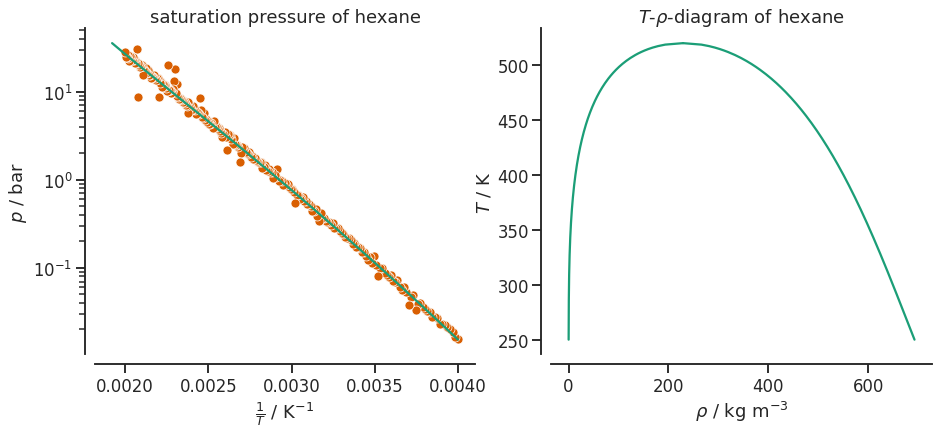

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax[0].set_title("saturation pressure of hexane")

sns.lineplot(
    y=phase_diagram.vapor.pressure / BAR,
    x=1.0/phase_diagram.vapor.temperature * KELVIN,
    ax=ax[0]
)
sns.scatterplot(
    x=1.0 / data_psat["temperature / K"], 
    y=data_psat["vapor_pressure / bar"], 
    ax=ax[0],
    color=colors[1]
)
ax[0].set_yscale('log')
ax[0].set_xlabel(r'$\frac{1}{T}$ / K$^{-1}$');
ax[0].set_ylabel(r'$p$ / bar');
#ax[0].set_xlim()
#ax[0].set_ylim()

ax[1].set_title(r"$T$-$\rho$-diagram of hexane")
sns.lineplot(
    y=phase_diagram.vapor.temperature / KELVIN,
    x=phase_diagram.vapor.mass_density / KILOGRAM * METER**3,
    ax=ax[1],
    color=colors[0]
)
sns.lineplot(
    y=phase_diagram.liquid.temperature / KELVIN,
    x=phase_diagram.liquid.mass_density / KILOGRAM * METER**3,
    ax=ax[1],
    color=colors[0]
)

ax[1].set_ylabel(r'$T$ / K');
ax[1].set_xlabel(r'$\rho$ / kg m$^{-3}$');

sns.despine(offset=10)

# Summary

- The `Estimator` object in FeO allows the collection of `DataSet` objects for adjusting parameters.
  - The `Estimator` takes a list of `DataSet` objects, weights, and `Loss` objects as inputs.
  - It calculates the cost of a model by evaluating the relative difference between the model's prediction and experimental data in each `DataSet`.
- To work with `scipy`'s `least_squares` solver, a cost function is required.
  - Two convenient functions, `eos_from_parameters` and `cost`, are built for this purpose.
  - `eos_from_parameters` constructs the parameters and equation of state for the current parameter vector.
  - `cost` calculates and returns the cost of the current model based on the parameters and estimator.
- Initial parameter guesses and parameter bounds are necessary for parameter adjustment.
  - Checking multiple combinations of initial parameters is recommended to avoid local optima.
- The `Estimator.mean_absolute_relative_difference` method provides the mean absolute relative difference (MARD) for each `DataSet`, without applying losses or weights.
  - The resulting MARD does not include the effects of loss functions or weights and does not represent the minimized property.